# 텍스트 다중분류
- EDA
- 데이터 전처리
- 모델
    - AutoKeras
    - LSTM
    

## EDA

In [1]:
import os
import pandas as pd
import tensorflow
import numpy as np
import matplotlib
import os
import re
import sentencepiece as spm
import matplotlib.pyplot as plt
import tensorflow as tf

train_data_path ="~/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [2]:
class_counts = train_data.groupby('class').size()
print(class_counts)

class
갈취 대화           981
기타 괴롭힘 대화      1094
직장 내 괴롭힘 대화     979
협박 대화           896
dtype: int64


In [31]:
train_data[train_data['class']=='협박 대화']

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
12,12,협박 대화,네네 무슨 일 때문에 전화주셨나요?\n우리 애가 지우개 하나 훔친거 가지고 애들 앞...
20,20,협박 대화,너가 민수라는 남자 제자니?\n네 맞는데요 왜 그러시죠? 혹시 저희 선생님께 무슨 ...
23,23,협박 대화,나좀 제발 그만 따라다녀.부탁이야\n너 만나려면 널 찾아가야될거아냐\n우리 헤어졌자...
...,...,...,...
3924,3924,협박 대화,때리지 말아줘\n 아퍼? 아프면 참아봐.\n나 이미 충분히 병원다니고 있어.\n병원...
3925,3925,협박 대화,오랜만이다. 여기 니 인질\n그래. 형이 무사히 다 빠져나가고 나면 그 다음에 이야...
3926,3926,협박 대화,아가씨 너희 집 어딘지 이제 아는데.\n 선생님 제발 우리 집에는 오지 마세요.\n...
3929,3929,협박 대화,안녕하세요 중고나라보고 문의드려요\n네 아이폰 50만원에 팔아요\n네 입금했습니다\...


In [3]:
x_train = train_data['conversation']
y_train = train_data['class']

### 데이터 길이, 클래스 분포 확인

데이터 정보
--------------------------------------------------
x_train : (3950,)
y_train : (3950,)
label 종류: {'갈취 대화', '협박 대화', '기타 괴롭힘 대화', '직장 내 괴롭힘 대화'}
--------------------------------------------------
클래스의 수 : 4
--------------------------------------------------
훈련용 뉴스의 최대 길이 :874
훈련용 뉴스의 평균 길이 :226.57088607594937


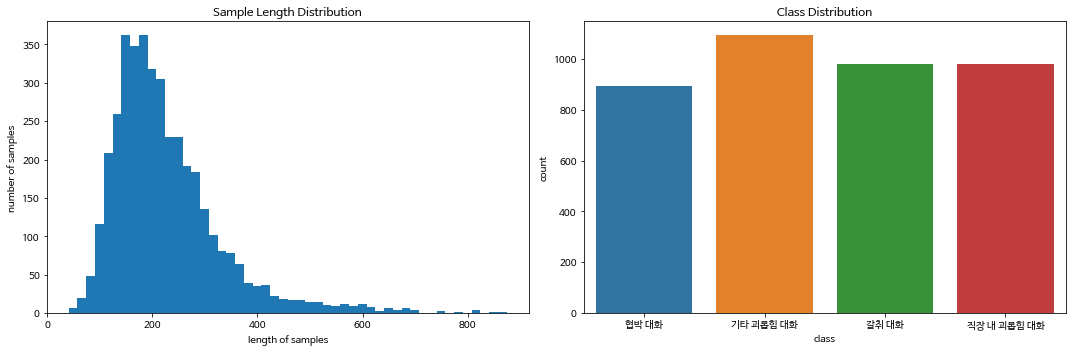

In [4]:
import matplotlib.pyplot as plt
# Colab에서 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
import numpy as np
import pandas as pd
import seaborn as sns

print('데이터 정보')
print('-'*50)
print('x_train :',x_train.shape)
print('y_train :',y_train.shape)
print('label 종류:', set(y_train))
print('-'*50)
num_classes = 4
print('클래스의 수 : {}'.format(num_classes))
print('-'*50)
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the histogram of sample lengths
axes[0].hist([len(s) for s in x_train], bins=50)
axes[0].set_xlabel('length of samples')
axes[0].set_ylabel('number of samples')
axes[0].set_title('Sample Length Distribution')

# Plot the count of each class
sns.countplot(x=y_train, ax=axes[1])
axes[1].set_title('Class Distribution')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

데이터 길이 분포는 200정도의 길이가 가장 많고 최대 874 길이이다.

클래스별 분포의 경우 일정하지만 기타 괴롭힘 대화가 가장 많고 협박 대화가 가장 적다.

### 데이터 클래스별 길이 분포 확인

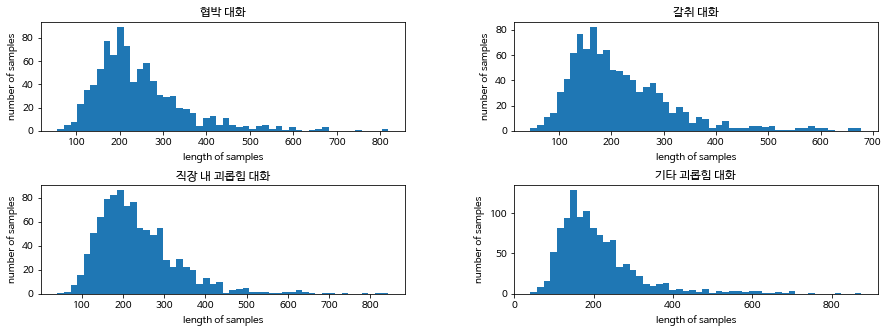

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

# Plot the histogram of sample lengths
axes[0][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='협박 대화']], bins=50)
axes[0][0].set_xlabel('length of samples')
axes[0][0].set_ylabel('number of samples')
axes[0][0].set_title('협박 대화')

axes[0][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='갈취 대화']], bins=50)
axes[0][1].set_xlabel('length of samples')
axes[0][1].set_ylabel('number of samples')
axes[0][1].set_title('갈취 대화')

axes[1][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='직장 내 괴롭힘 대화']], bins=50)
axes[1][0].set_xlabel('length of samples')
axes[1][0].set_ylabel('number of samples')
axes[1][0].set_title('직장 내 괴롭힘 대화')

axes[1][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='기타 괴롭힘 대화']
], bins=50)
axes[1][1].set_xlabel('length of samples')
axes[1][1].set_ylabel('number of samples')
axes[1][1].set_title('기타 괴롭힘 대화')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

## 데이터 전처리

In [6]:
x_train[0]

'지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.\n 정말 잘못했습니다.\n 너가 선택해. 너가 죽을래 네 가족을 죽여줄까.\n 죄송합니다. 정말 잘못했습니다.\n 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.\n 선택 못하겠습니다. 한번만 도와주세요.\n 그냥 다 죽여버려야겠군. 이의 없지?\n 제발 도와주세요.'

In [7]:
x_train[100]

'어이 초딩. 이리 와봐\n 누구세요\n 이리와보라고 자식아. 죽고싶냐\n 왜 이러세요 \n 확! 죽을래? 조용히 이리 안와?\n 무서워요\n 돈 얼마있어. 다 내놔봐.\n 저 돈 없어요\n 씨발. 죽을래. 너 어디살아. 가진거 다 내놔봐.\n 왜 이러세요\n 산에 가서 확 묻어버리기 전에 호주머니에 있는거 다 내놔\n 이러지 마세요'

In [ ]:
# 문장부호, 앞뒤로 공백 넣기

### sentencepiece를 이용한 tokenizer 생성


In [8]:
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    # 문장 데이터를 파일로 저장
    with open(f"{lang}_corpus.txt", "w") as f:
        for sentence in corpus:
            f.write(sentence + "\n")
    
    model_prefix = f"{lang}_tokenizer"
    
    # Train SentencePiece tokenizer
    spm.SentencePieceTrainer.train(
        f"--input={lang}_corpus.txt --model_prefix={model_prefix} --vocab_size={vocab_size}" + 
        f" --pad_id={pad_id} --pad_piece=[PAD]" +
        f" --unk_id={unk_id} --unk_piece=[UNK]" +
        f" --bos_id={bos_id} --bos_piece=[BOS]" +
        f" --eos_id={eos_id} --eos_piece=[EOS]" +
        " --model_type=unigram --max_sentence_length=999999")

    # Load tokenizer
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")
    
    return tokenizer

In [9]:
SRC_VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(x_train, SRC_VOCAB_SIZE, 'ko')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_corpus.txt --model_prefix=ko_tokenizer --vocab_size=20000 --pad_id=0 --pad_piece=[PAD] --unk_id=3 --unk_piece=[UNK] --bos_id=1 --bos_piece=[BOS] --eos_id=2 --eos_piece=[EOS] --model_type=unigram --max_sentence_length=999999
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extreme

In [10]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 400
EMBEDDING_DIM = 256


In [11]:
filtered_train = train_data[train_data['conversation'].apply(len) <= 400]
print("원본데이터크기:", len(train_data))
print("전처리후데이터크기:", len(filtered_train))


원본데이터크기: 3950
전처리후데이터크기: 3706


In [44]:
test_data_path ="~/data/test.json"
test_data = pd.read_json(test_data_path)
test_data = test_data.T
test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...


In [47]:
sample = pd.read_json("~/data/sample_answersheet.json")

<bound method NDFrame.head of        class
t_000      1
t_001      2
t_002      2
t_003      4
t_004      3>

In [48]:
# 패딩처리
pad_train = tf.keras.preprocessing.sequence.pad_sequences(
    [tokenizer.encode_as_ids(sentence) for sentence in filtered_train['conversation']],
    padding='post'
)

In [13]:
print(pad_train)

[[   27     8  3061 ...     0     0     0]
 [14794   313     4 ...     0     0     0]
 [    8   829 18860 ...     0     0     0]
 ...
 [  139   291   262 ...     0     0     0]
 [  351  7848   270 ...     0     0     0]
 [ 5254    10     5 ...     0     0     0]]


In [14]:
pad_train.shape

(3706, 185)

In [15]:
Y = pd.get_dummies(filtered_train['class']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3706, 4)


In [16]:
# split
from sklearn.model_selection import train_test_split

# 이후 train_test_split을 사용하여 데이터를 나누는 코드 작성

X_train, X_val, Y_train, Y_val = train_test_split(pad_train,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(3335, 185) (3335, 4)
(371, 185) (371, 4)


## 모델링
### lstm

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1])) #X_train.shape[1]
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
47/47 [==============================] - 35s 697ms/step - loss: 1.3852 - accuracy: 0.2736 - val_loss: 1.3832 - val_accuracy: 0.2964
Epoch 2/100
47/47 [==============================] - 32s 686ms/step - loss: 1.3860 - accuracy: 0.2746 - val_loss: 1.3859 - val_accuracy: 0.2156
Epoch 3/100
47/47 [==============================] - 32s 688ms/step - loss: 1.3844 - accuracy: 0.2709 - val_loss: 1.3831 - val_accuracy: 0.2964
Epoch 4/100
47/47 [==============================] - 32s 685ms/step - loss: 1.3832 - accuracy: 0.2799 - val_loss: 1.3805 - val_accuracy: 0.2964
Epoch 5/100
47/47 [==============================] - 32s 684ms/step - loss: 1.3836 - accuracy: 0.2792 - val_loss: 1.3811 - val_accuracy: 0.2964
Epoch 6/100
47/47 [==============================] - 32s 687ms/step - loss: 1.3844 - accuracy: 0.2809 - val_loss: 1.3820 - val_accuracy: 0.2964
Epoch 7/100
47/47 [==============================] - 32s 685ms/step - loss: 1.3837 - accuracy: 0.2822 - val_loss: 1.3800 - val_accuracy:

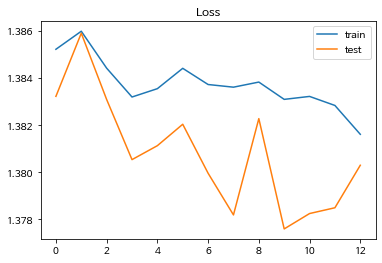

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

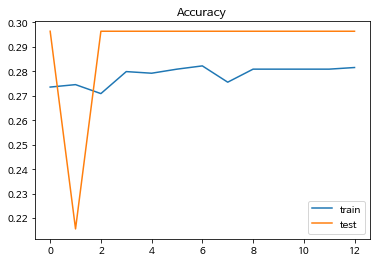

In [22]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [35]:
ls

data@          ko_tokenizer.model  proj_lstm.ipynb
ko_corpus.txt  ko_tokenizer.vocab  Untitled.ipynb


In [51]:
Y_train

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [53]:
pad_test = tf.keras.preprocessing.sequence.pad_sequences(
    [tokenizer.encode_as_ids(sentence) for sentence in test_data['text']],
    padding='post'
)
pred = model.predict(pad_test)
pred
#print(pred, labels[np.argmax(pred)])

array([[0.25821203, 0.27795088, 0.24270573, 0.22113138],
       [0.25821203, 0.27795088, 0.24270573, 0.22113138],
       [0.25821203, 0.27795088, 0.24270573, 0.22113138],
       ...,
       [0.25821203, 0.27795088, 0.24270573, 0.22113138],
       [0.25821203, 0.27795088, 0.24270573, 0.22113138],
       [0.25821203, 0.27795088, 0.24270573, 0.22113138]], dtype=float32)

In [54]:
np.argmax(pred)

535

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Define the LSTM model as a function
def create_lstm_model(embedding_dim=100, lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, embedding_dim, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create KerasClassifier based on the LSTM model
lstm_classifier = KerasClassifier(build_fn=create_lstm_model, verbose=0)

# Define hyperparameters to search
param_grid = {
    'embedding_dim': [100, 200],
    'lstm_units': [50, 100],
    'dropout_rate': [0.2, 0.4],
    'batch_size': [32, 64]
}

early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Create GridSearchCV instance
grid = GridSearchCV(estimator=lstm_classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Perform the grid search on training data
grid_result = grid.fit(X_train, Y_train, callbacks=[early_stopping, model_checkpoint])



In [ ]:

# Print the best hyperparameters and results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Get the best model from the grid search
best_model = grid_result.best_estimator_.model

# Save the best model to a file using joblib
joblib.dump(best_model, 'best_lstm_model.pkl')

# Load the best model later
loaded_model = joblib.load('best_lstm_model.pkl')

# Make predictions using the loaded model
Y_pred = loaded_model.predict(X_test)
accuracy = accuracy_score(np.argmax(Y_test, axis=1), Y_pred)
print("Test accuracy: %.4f" % accuracy)
